# 1. Collect dataset
&emsp;&emsp; We collect different faces of different cubes in different light colors(ambient) shot by different cameras. 
To make a dataset easily, we shoot video. In each video, the cube, the face color, the light color and the camera hold same. 
We only change light intensity. After shooting videos, we tag their labels. Then, we begin make dataset of the cubes.

In [1]:
!pwd

/home/ytj/Desktop/profile/easy_cube/rest_server/colordetect


## 1.1 Clipping videos
&emsp;&emsp; Clip the videos in /video directory

In [2]:
import cv2
import numpy as np
import os
from multiprocessing import Pool

v_ext_names = ['mov', 'mp4', 'avi']

def read_images(video_file_name):
    video = cv2.VideoCapture(video_file_name)
    frames = []
    while True:
        success, frame = video.read()
        if not success:
            break
        frames.append(frame)
    return np.stack(frames, axis=0)

def handle_video(v_name):
    v_path = os.path.join('video', v_name)
    pic_path = os.path.join('video_frames', v_name)
    if not os.path.exists(pic_path):
        os.mkdir(pic_path)
    frames = read_images(v_path)
    frames_count = frames.shape[0]
    for i in np.arange(frames_count):
        frame = frames[i]
        cv2.imwrite(os.path.join(pic_path, str(i) + '.png'), frame)

pool = Pool(processes=8)
video_names = list(filter(lambda x: ('.' in x) and (x.split('.')[-1].lower() in v_ext_names 
                                                    and not x.startswith('.')) , os.listdir('./video')))
for v_name in video_names:
    pool.apply_async(handle_video, args=(v_name,))
pool.close()
pool.join()
        

## 1.2 Rubik's cube separation
&emsp;&emsp; Separate rubik cube in the pictures and generate labels in 'label' directory.

In [3]:
import cv2
import numpy as np
import pandas as pd
import os
from multiprocessing import Pool

def clip_one_picture(picture_file, ux, uy, dx, dy, output_file):
    img = cv2.imread(picture_file)
    img = img[ux: dx + 1, uy: dy + 1, :]
    cv2.imwrite(output_file, img)

def list_images(dir_name):
    img_suffix = ['png', 'jpg']
    images = filter(lambda x: '.' in x and x.split('.')[-1].lower() in img_suffix, os.listdir(dir_name))
    return list(images)

def clip_multiple_pictures(input_file_names, ux, uy, dx, dy, output_dir_name, start_number):
    idx = start_number
    for img_file_name in input_file_names:
        img_out_name0 = os.path.join(output_dir_name, str(idx)) + '.png'
        clip_one_picture(img_file_name, ux, uy, dx, dy, img_out_name0)
        idx += 1

In [4]:
    
print("Please wait")

video_dir_names = filter(lambda x: '.' in x and x.split('.')[-1].lower() == 'mov' and not x.startswith('.')
                         , os.listdir('video_frames'))
tb_video = pd.read_csv('./label/label_video.tsv', sep='\t', index_col='id',
                       dtype={'id': int})
# tb_picture = pd.DataFrame(columns=['id', 'camera', 'light_color', 'cube_id', 'cube_color', 
#                                    'video_file_name', 'picture_file_name'], index=['id'])
tb_picture = []
pool = Pool(8)

dict_video_file_name_to_info = dict()
columns = ['camera', 'light_color', 'cube_id', 'cube_color', 'file_name', 'ux', 'uy', 'dx', 'dy']
ids = list(tb_video.index)
for i in range(len(tb_video)):
    file_name = tb_video.loc[ids[i], 'file_name']
    dict_video_file_name_to_info[file_name] = {}
    for c in columns:
        dict_video_file_name_to_info[file_name][c] = tb_video.loc[ids[i], c]

MULTITHREAD = True
i = 0
for video_dir_name in video_dir_names:
    video_dir_name0 = os.path.join('video_frames', video_dir_name)
    image_file_mames = list_images(video_dir_name0)
    input_file_names = [os.path.join(video_dir_name0, name) for name in image_file_mames]
    endi = i + len(image_file_mames)
    
    if video_dir_name not in dict_video_file_name_to_info:  # some videos in video_frames directory may not have been labeled
        continue
    info = dict_video_file_name_to_info[video_dir_name]
    if MULTITHREAD:
        pool.apply_async(clip_multiple_pictures, args=(input_file_names, info['ux'], info['uy'], 
                                                       info['dx'], info['dy'], 'clipped_video_frames', i))
    else:
        clip_multiple_pictures(input_file_names, info['ux'], info['uy'], info['dx'], info['dy'], 
                               'clipped_video_frames', i)
    for j in np.arange(i, endi):
        pic_info = info.copy()
        pic_info.pop('file_name')
        pic_info.pop('ux')
        pic_info.pop('uy')
        pic_info.pop('dx')
        pic_info.pop('dy')
        pic_info['video_file_name'] = info['file_name']
        pic_info['picture_file_name'] = str(j) + '.png'
        pic_info['id'] = j
        tb_picture.append(pic_info)
    i = endi

tb_picture = pd.DataFrame.from_records(tb_picture, index=['id'])

pool.close()
pool.join()
tb_picture.to_csv('./label/label_picture.tsv', sep='\t')
print("Finish")

Please wait
Finish


# 1.3 Rubik's cube color block separation
&emsp;&emsp; In this subsection, we separate color blocks in the rubik cube. And by the way generate the label of those 
color blocks. Hence, we will have a block dataset of the rubik's cube.

In [5]:
import os
import cv2
import pandas as pd
from multiprocessing import Pool

def cut3x3(picture_file, output_directory, start_number):
    img = cv2.imread(picture_file)
    h, w, c = img.shape
    h0 = h // 3
    w0 = w // 3
    k = start_number
    for i in range(3):
        for j in range(3):
            img2 = img[i * h0: (i + 1) * h0, j * w0: (j + 1) * w0, :]
            cv2.imwrite(os.path.join(output_directory, str(k)) + '.png', img2)
            k += 1

label_pictures = pd.read_csv('./label/label_picture.tsv', sep='\t', index_col='id')

label_blocks = []
columns = label_pictures
ids = label_pictures.index

pool = Pool(8)

position_strings = ['UL', 'UM', 'UR', 'ML', 'MM', 'MR', 'DL', 'DM', 'DR']

k = 0
MULTITHREAD = True
for i in range(len(label_pictures)):
    file_name = label_pictures.loc[ids[i], 'picture_file_name']
    picture_file = os.path.join('./clipped_video_frames', file_name)
    if MULTITHREAD:
        pool.apply_async(cut3x3, args=(picture_file, './clipped_color_blocks', k))
    else:
        cut3x3(picture_file, './clipped_color_blocks', k)
    
    record = label_pictures.loc[ids[i]].to_dict()
    for j in range(9):
        record2 = record.copy()
        record2['block_file_name'] = str(k + j) + '.png'
        record2['block_position'] = position_strings[j]
        record2['id'] = k + j
        label_blocks.append(record2)    
    k += 9

label_blocks = pd.DataFrame.from_records(label_blocks, index=['id'])
label_blocks.to_csv('./label/label_block.tsv', sep='\t')
pool.close()
pool.join()

print("Finish")

Finish


# 2. Plot the distribution of different cubes

## 2.1 Data visualization 3d and PCA

 &emsp;&emsp; In colordetect/data folder, we have examples of red cube, blue cube, and green cube. In each of these directory, 
 we present different cubes.  
 &emsp;&emsp; After that, we write functions to identify color.
 

In [9]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os

# Extract dataset from a table. Tuple(X, y). X is a list of pictures, y is a list of labels
def make_dataset(table, preprocess_fn=None):
    ids = table.index
    X = []
    y = []
    for i in range(len(table)):
        line = table.loc[ids[i]]
        label = {
            "color": line['cube_color']
        }
        block_file_name = os.path.join('./clipped_color_blocks', line['block_file_name'])
        img = cv2.imread(block_file_name)
        if preprocess_fn is not None:
            img = preprocess_fn(img)
        X.append(img)
        y.append(label)
    return X, y

In [10]:
def extract_one_feature(x):
    h, w, c = x.shape
    x1 = x[int(0.2 * h): int(0.8 * h), int(0.2 * w): int(0.8 * w), :]
    x1 = x1.transpose((2, 0, 1))
    x1 = x1.reshape((c, -1))
    ft = np.mean(x1, axis=1)
    return ft

In [11]:
def extract_features(X):
    ret = []
    for x in X:
        ft = extract_one_feature(x)
        ret.append(ft)
    return np.vstack(ret)

In [12]:
label_blocks = pd.read_csv('./label/label_block.tsv', sep='\t')
(X_img, y) = make_dataset(label_blocks)

In [13]:
ft = extract_features(X_img)

&emsp;&emsp;From the figure below, we can see that different color has a relatively clear distribution, but there might be some confusion if it is too dark(RGB = 000000) or too light(RGB = FFFFFF). <br>
&emsp;&emsp;The distribution is like a cone, which seems like HSV representation.

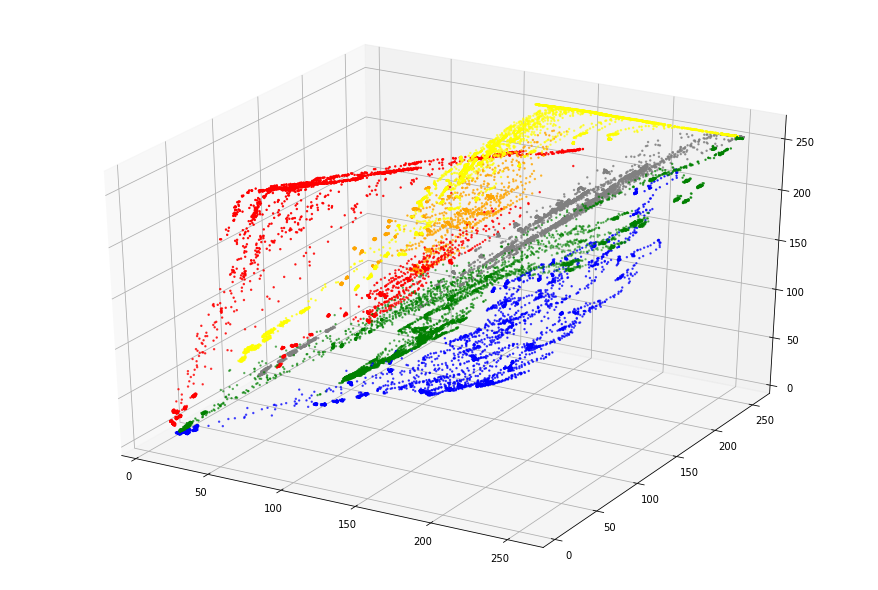

In [14]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

colormap = {'G': 'g', 'Y': 'yellow', 'O': 'orange', 'B': 'b', 'R': 'r', 'W': 'grey'}
fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig)
ax.scatter3D(ft[:, 0], ft[:, 1], ft[:, 2], s=2, c=[colormap[y0['color']] for y0 in y])
plt.show()

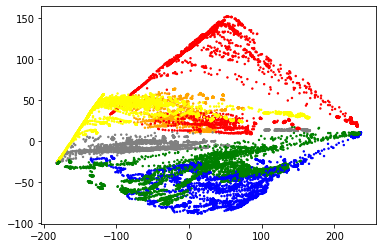

In [15]:
from sklearn.decomposition import PCA
model = PCA(n_components=2)
ft_trans = model.fit_transform(ft)
plt.scatter(ft_trans[:, 0], ft_trans[:, 1], s=2, c=[colormap[y0['color']] for y0 in y])
plt.show()

## 2.2 Try to train a network model and compare it with 1-NN classifier

&emsp;&emsp;The 1-nn classifier gives the lower bound of the accuracy of the ideal classifier in current feature space. In this section, we compare MLP with 1-nn baseline. To run this part, you should run the former part first to get data.

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

def train_model(X_train, y_train, standardization=True, output_loss_curve=True):
    if standardization:
        X_train = StandardScaler().fit(X_train).transform(X_train)
    clf = MLPClassifier(hidden_layer_sizes=(6, 15, 6), activation='relu', solver='adam', 
                        max_iter=500, alpha=0.01,learning_rate_init=5e-4, early_stopping=True, 
                        validation_fraction=0.2)
    clf.fit(X_train, y_train)
    loss_curve = clf.loss_curve_
    if output_loss_curve:
        return clf, loss_curve
    else:
        return clf

def train_knn_model(X_train, y_train, k, standardization=True):
    if standardization:
        X_train = StandardScaler().fit(X_train).transform(X_train)
    clf = KNeighborsClassifier(n_neighbors=k)
    model = clf.fit(X_train, y_train)
    return model

def test_model(X_test, y_test, model, standardization=True):
    if standardization:
        X_test = StandardScaler().fit(X_test).transform(X_test)
    prob = model.predict_proba(X_test)
    prd = np.argmax(prob, axis=1)
    acc = (prd == y_test).sum() / X_test.shape[0]
    return acc

def inference(X_test, model, standardization=True, return_prob=False):
    if standardization:
        X_test = StandardScaler().fit(X_test).transform(X_test)
    prob = model.predict_proba(X_test)
    if return_prob:
        return prob
    else:
        return np.argmax(prob, axis=1)

def test_model_with_rejection(X_test, y_test, model, accept_threshold=0.7, standardization=True):
    if standardization:
        X_test = StandardScaler().fit(X_test).transform(X_test)
    prob = model.predict_proba(X_test)
    prd = np.argmax(prob, axis=1)
    
    max_prob = np.max(prob, axis=1)
    prd_qualified = (max_prob > accept_threshold)
    
    prd0 = prd[prd_qualified]
    y_qualified = y_test[prd_qualified]
    
    accpt_rate = (prd_qualified).sum() / X_test.shape[0]
        
    acc = (prd0 == y_qualified).sum() / X_test.shape[0]
    return acc, accpt_rate

### 2.2.1 The convergence of neural network
&emsp;&emsp; We will tune a feasible parameter of neural network.

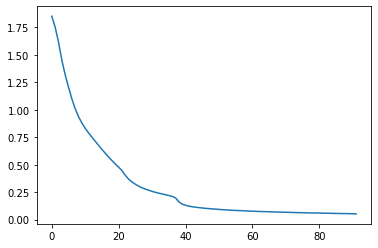

Network acc: 0.986839378238342


In [17]:
from sklearn.model_selection import train_test_split

def exp_convergence():
    colormap2 = {'W': 0, 'R': 1, 'G': 2, 'Y': 3, 'O': 4, 'B': 5}
    lb = np.array([colormap2[q['color']] for q in y])
    X_train, X_test, y_train, y_test = train_test_split(ft, lb, test_size=0.33)
    model, loss_curve = train_model(X_train, y_train)

    plt.figure()
    plt.plot(loss_curve)
    plt.show()
    
    acc = test_model(X_test, y_test, model)
    print("Network acc: {}".format(acc))
exp_convergence()

### 2.2.2 The sensitivity of KNN with respect to 'k'
&emsp;&emsp; We will try k from 1 to 100 and show the accuracy.

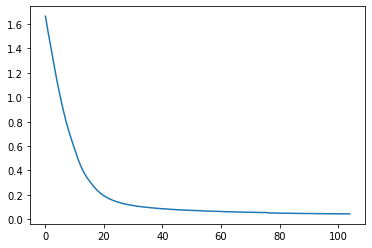

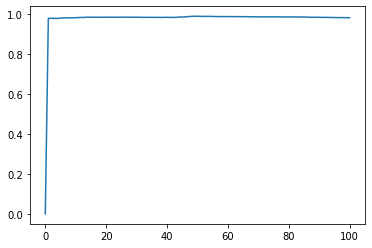

Network acc: 0.9882901554404145
49-NN acc: 0.9889119170984456


In [18]:
from sklearn.model_selection import train_test_split

colormap2 = {'W': 0, 'R': 1, 'G': 2, 'Y': 3, 'O': 4, 'B': 5}
lb = np.array([colormap2[q['color']] for q in y])
X_train, X_test, y_train, y_test = train_test_split(ft, lb, test_size=0.33)
model, loss_curve = train_model(X_train, y_train)

opt = 0
optk = 0
knn_accs = [0]
for k in range(1, 101):
    model_knn = train_knn_model(X_train, y_train, k)
    acc = test_model(X_test, y_test, model_knn)
    if acc > opt:
        opt = acc
        optk = k
    knn_accs.append(acc)
    
plt.figure()
plt.plot(loss_curve)
plt.figure()
plt.plot(knn_accs)

plt.show()
acc = test_model(X_test, y_test, model)
print("Network acc: {}".format(acc))
print("{}-NN acc: {}".format(optk, opt))

In [19]:
from sklearn.model_selection import train_test_split

def conduct_comparison(ft, lb, exp_id, random_state):
    colormap2 = {'W': 0, 'R': 1, 'G': 2, 'Y': 3, 'O': 4, 'B': 5}
    X_train, X_test, y_train, y_test = train_test_split(ft, lb, test_size=0.33, random_state=random_state)
    model, loss_curve = train_model(X_train, y_train)

    opt = 0
    optk = 0
    optaccpt = 0
    for k in range(1, 101):
        model_knn = train_knn_model(X_train, y_train, k)
        acc, accpt_rate = test_model_with_rejection(X_test, y_test, model_knn, accept_threshold=0.8)
        if acc > opt:
            opt = acc
            optk = k
            optaccpt = accpt_rate

#     plt.figure()
#     plt.title("Experiment {}".format(exp_id))
#     plt.plot(loss_curve)
    
#     plt.show()
    acc, accpt = test_model_with_rejection(X_test, y_test, model, accept_threshold=0.6)
#     print("Network acc: {}. Rejection rate: {}".format(acc, rj_rate))
#     print("{}-NN acc: {}. Rejection rate: {}".format(optk, opt, optrj))
    return opt, acc, optaccpt, accpt

In [14]:
exp_time = 20
seeds = np.random.randint(0, 10000, size=(20,))

colormap2 = {'W': 0, 'R': 1, 'G': 2, 'Y': 3, 'O': 4, 'B': 5}
lb = np.array([colormap2[q['color']] for q in y])
knn_accs = []
nn_accs = []
knnrjs = []
nnrjs = []
for i in range(len(seeds)):
    knn_acc, nn_acc, knnrj, nnrj = conduct_comparison(ft, lb, i + 1, seeds[i])
    knn_accs.append(knn_acc)
    nn_accs.append(nn_acc)
    knnrjs.append(knnrj)
    nnrjs.append(nnrj)

KeyboardInterrupt: 

## 2.3 Train convolutional neural network for detecting the color

In [20]:
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.optim as optim 
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt

def cal_size(i, p, k, st):
    return (i + 2 * p - k) // st + 1

class Lenet5Module(nn.Module):
    
    def __init__(self, c, s):
        super(Lenet5Module, self).__init__()
        
        # --------------------hyper parameters ----------------------
        conv1_in_chn = c
        conv1_out_chn = 3 * c
        conv1_kernel_size = 5
        conv1_stride = 1
        conv1_padding = 1
        
        pool1_padding = 0
        pool1_kernel_size = 2
        pool1_stride = 2
        
        conv2_out_chn = 16
        conv2_kernel_size = 5
        conv2_stride = 1
        conv2_padding = 0
        
        pool2_padding = 0
        pool2_kernel_size = 2
        pool2_stride = 2
        
        fc1_out = 120
        fc2_out = 84
        
        #---------------------const hyperparameters-----------------
        category = 6
        
        #---------------------derived parameters--------------------
            
        conv1_fm_size = cal_size(s, conv1_padding, conv1_kernel_size, conv1_stride)
        pool1_fm_size = cal_size(conv1_fm_size, pool1_padding, pool1_kernel_size, pool1_stride)
        conv2_fm_size = cal_size(pool1_fm_size, conv2_padding, conv2_kernel_size, conv2_stride)
        pool2_fm_size = cal_size(conv2_fm_size, pool2_padding, pool2_kernel_size, pool2_stride)
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(c, conv1_out_chn, conv1_kernel_size, conv1_stride, conv1_padding),
            nn.ReLU(),
            nn.MaxPool2d(pool1_kernel_size, pool1_stride, pool1_padding)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(conv1_out_chn, conv2_out_chn, conv2_kernel_size, conv2_stride, conv2_padding),
            nn.ReLU(),
            nn.MaxPool2d(pool2_kernel_size, pool2_stride, pool2_padding)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(conv2_out_chn * pool2_fm_size * pool2_fm_size, fc1_out),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(fc1_out, fc2_out),
            nn.ReLU()
        )
        self.fc3 = nn.Linear(fc2_out, category)
    
    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = X.view(X.size()[0], -1)
        X = self.fc1(X)
        X = self.fc2(X)
        X = self.fc3(X)
        return X

class ConvolutionalDetector(BaseEstimator, TransformerMixin):
    
    # The default setting is for opencv
    def __init__(self,
                 img_size=28,
                 lr=1e-4,
                 batch_size=20,
                 epochs=30,
                 scale=True, 
                 input_format='NHWC',
                 color_format='BGR',
                 device='cpu',
                 debug=False):
        super(self.__class__, self).__init__()
        
        self.model = {
            "state": False,   # Whether it is trained or not
            "model": None,
            "setting": {
                "in_format": input_format,
                "color_format": color_format
            }
        }
        
        self.param = {
            "scale": scale,
            "batch_size": batch_size,
            "epochs": epochs,
            "lr": lr
        }
        
        self.device = device
        self.debug = debug
    
    def _scale(self, X, is_train):
        if self.param['scale']:
            X = X / 255.0
        return X
    
    def _transform_representation(self, X):
        '''
        The representation should be NCHW and color format is rgb
        '''
        if self.model['setting']['in_format'] == 'NHWC':
            X = np.transpose(X, (0, 3, 1, 2)).copy()
        if self.model['setting']['color_format'] == 'BGR':
            X = X[:, :, :, ::-1].copy()
        return X
    
    # Procedures before feeding data into network
    def _preprocess(self, X, y=None, is_train=False, output_tensor=True):
        X = self._scale(X, is_train)
        X = self._transform_representation(X)
        if output_tensor:
            X = torch.FloatTensor(X)
            if y is not None:
                y = torch.LongTensor(y)
        if y is None:
            return X
        else:
            return X, y
    
    # Procedures before returning data to the caller
    def _postprocess(self, X, y):
        pass
    
    
    def fit(self, X, y):
        
        X, y = self._preprocess(X, y, is_train=True)
        dataset = TensorDataset(X, y)
        
        model = Lenet5Module(3, X.shape[2])
        loader = DataLoader(dataset, batch_size=self.param['batch_size'], shuffle=True)
        
        criterion = nn.CrossEntropyLoss()
        
        if self.debug:
            losses = []
        
        model.to(self.device, non_blocking=False)
        # print("-----------model initialized-----------------")
        optimizer = optim.Adam(model.parameters(), lr=self.param['lr'])
        for e in range(self.param['epochs']):
            for i, data in enumerate(loader):
                inputs, labels = data
                inputs = inputs.to(self.device)
                optimizer.zero_grad()
                outputs = model(inputs).cpu()
                loss = criterion(outputs, labels)

                if self.debug:
#                     print("Epoch {} step {}. Loss = {}".format(e, i, loss.item()))
                    losses.append(loss.item())

                loss.backward()
                optimizer.step()

        self.model['model'] = model
        self.model['state'] = True
        
        if self.debug:
            plt.plot(np.array(losses))
            plt.show()
        
    
    def predict_proba(self, X):
        X = self._preprocess(X, is_train=False)
        dataset = TensorDataset(X)
        loader = DataLoader(dataset, batch_size=self.param['batch_size'], shuffle=False)
        
        probs = []
        model = self.model['model']
        
        model.to(self.device)
        with torch.no_grad():
            for i, data in enumerate(loader):
                inputs = data[0]
                inputs = inputs.to(self.device)
                outputs = model(inputs)
                prob = F.softmax(outputs, dim=1)
                probs.append(outputs.cpu().numpy())
            probs = np.concatenate(probs, axis=0)
        return probs
                
    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)
        


In [21]:
import cv2

def create_preprocess_fn(d):
    def preprocess_fn(img0):
        img0 = cv2.resize(img0, (d, d), interpolation=cv2.INTER_AREA)
        return img0
    return preprocess_fn

In [22]:
d = 28
label_blocks = pd.read_csv('./label/label_block.tsv', sep='\t')
(X_img, y) = make_dataset(label_blocks, preprocess_fn=create_preprocess_fn(d))

In [23]:
X_img = np.stack(X_img, axis=0)

In [24]:
X_img.shape

(29241, 28, 28, 3)

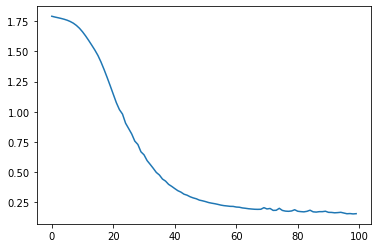

In [44]:
import torch
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cuda'
torch.cuda.current_device()
torch.cuda._initialized = True

colormap2 = {'W': 0, 'R': 1, 'G': 2, 'Y': 3, 'O': 4, 'B': 5}
lb = np.array([colormap2[q['color']] for q in y])
model = ConvolutionalDetector(d, lr=1e-3, batch_size=48000, epochs=100, device=device, debug=True)
model.fit(X_img, lb)

In [45]:
test_files = [x for x in os.listdir('test') if x.lower().endswith('.jpeg') and not x.startswith('.')]
test_files = sorted([os.path.join('test', x) for x in test_files])

predicts = []
process_fn = create_preprocess_fn(28)
for f in test_files:
    img = cv2.imread(f)
    feature_clip = []
    h, w, c = img.shape
    h0 = h // 3
    w0 = w // 3
    for i in range(0, 3):
        for j in range(0, 3):
            sub_img = img[i * h0: (i + 1) * h0, j * w0: (j + 1) * w0, :]
            sub_img = process_fn(sub_img)
            feature_clip.append(sub_img)
    feature_clip = np.stack(feature_clip, axis=0)
#     feature_clip_standard = scaler.transform(feature_clip)
    predict = inference(feature_clip, model, standardization=False, return_prob=False)
#     print(predict)
    predicts.append(predict.tolist())

In [46]:
colormap_inv = dict((x[1], x[0]) for x in colormap2.items())
print(test_files)
for x in predicts:
    predict_color = [colormap_inv[y] for y in x]
    print(predict_color)

['test/1.jpeg', 'test/10.jpeg', 'test/11.jpeg', 'test/12.jpeg', 'test/2.jpeg', 'test/3.jpeg', 'test/4.jpeg', 'test/5.jpeg', 'test/6.jpeg', 'test/7.jpeg', 'test/8.jpeg', 'test/9.jpeg']
['W', 'O', 'R', 'R', 'O', 'Y', 'O', 'Y', 'R']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R']
['B', 'B', 'G', 'B', 'G', 'G', 'B', 'B', 'G']
['G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G']
['O', 'O', 'G', 'R', 'R', 'W', 'B', 'R', 'G']
['W', 'G', 'O', 'W', 'G', 'Y', 'G', 'O', 'B']
['R', 'G', 'R', 'R', 'W', 'B', 'B', 'B', 'Y']
['Y', 'W', 'W', 'O', 'B', 'B', 'G', 'Y', 'O']
['R', 'G', 'R', 'R', 'W', 'B', 'B', 'B', 'Y']
['Y', 'W', 'B', 'G', 'Y', 'G', 'Y', 'B', 'W']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R']
['Y', 'G', 'G', 'Y', 'Y', 'Y', 'Y', 'G', 'G']


# 3. Detect the color sequence of the cube, given an image array that has been selected.

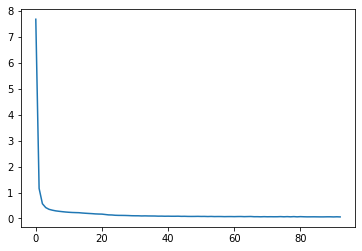

In [38]:
import os
import numpy as np
import cv2
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

colormap2 = {'W': 0, 'R': 1, 'G': 2, 'Y': 3, 'O': 4, 'B': 5}
colormap_inv = dict((x[1], x[0]) for x in colormap2.items())
lb = np.array([colormap2[q['color']] for q in y])
model, loss_curve = train_model(ft, lb, standardization=False, output_loss_curve=True)
scaler = StandardScaler().fit(ft)
plt.plot(loss_curve)
plt.show()

In [39]:
test_files = [x for x in os.listdir('test') if x.lower().endswith('.jpeg') and not x.lower().startswith('.')]
test_files = sorted([os.path.join('test', x) for x in test_files])

predicts = []
for f in test_files:
    img = cv2.imread(f)
    feature_clip = []
    h, w, c = img.shape
    h0 = h // 3
    w0 = w // 3
    for i in range(0, 3):
        for j in range(0, 3):
            sub_img = img[i * h0: (i + 1) * h0, j * w0: (j + 1) * w0, :]
            test_ft = extract_one_feature(sub_img)
            feature_clip.append(test_ft)
    feature_clip = np.stack(feature_clip, axis=0)
    feature_clip_standard = scaler.transform(feature_clip)
    predict = inference(feature_clip_standard, model, standardization=False)
    predicts.append(predict.tolist())

In [40]:
print(test_files)
for x in predicts:
    predict_color = [colormap_inv[y] for y in x]
    print(predict_color)

['test/1.jpeg', 'test/10.jpeg', 'test/11.jpeg', 'test/12.jpeg', 'test/2.jpeg', 'test/3.jpeg', 'test/4.jpeg', 'test/5.jpeg', 'test/6.jpeg', 'test/7.jpeg', 'test/8.jpeg', 'test/9.jpeg']
['G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G']
['G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G']
['G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G']
['G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G']
['G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G']
['G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G']
['G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G']
['G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G']
['G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G']
['G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G']
['G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G']
['G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G']
